# Linear regression

We have now built up all of the knowledge necessary to do some **data analysis**. We're going to start with something that you're probably very familiar with: finding a **line of best fit**.

In all of the following examples, we will be dealing with **abstract** data (i.e. $x$ and $y$ rather than volume and pressure or time and concentration etc), so as to focus on the methodology behind what we are doing rather than the details of the data itself.

Let's imagine that we've been given some experimental data that is evidently linear:

In [1]:
%config InlineBackend.figure_format='retina'

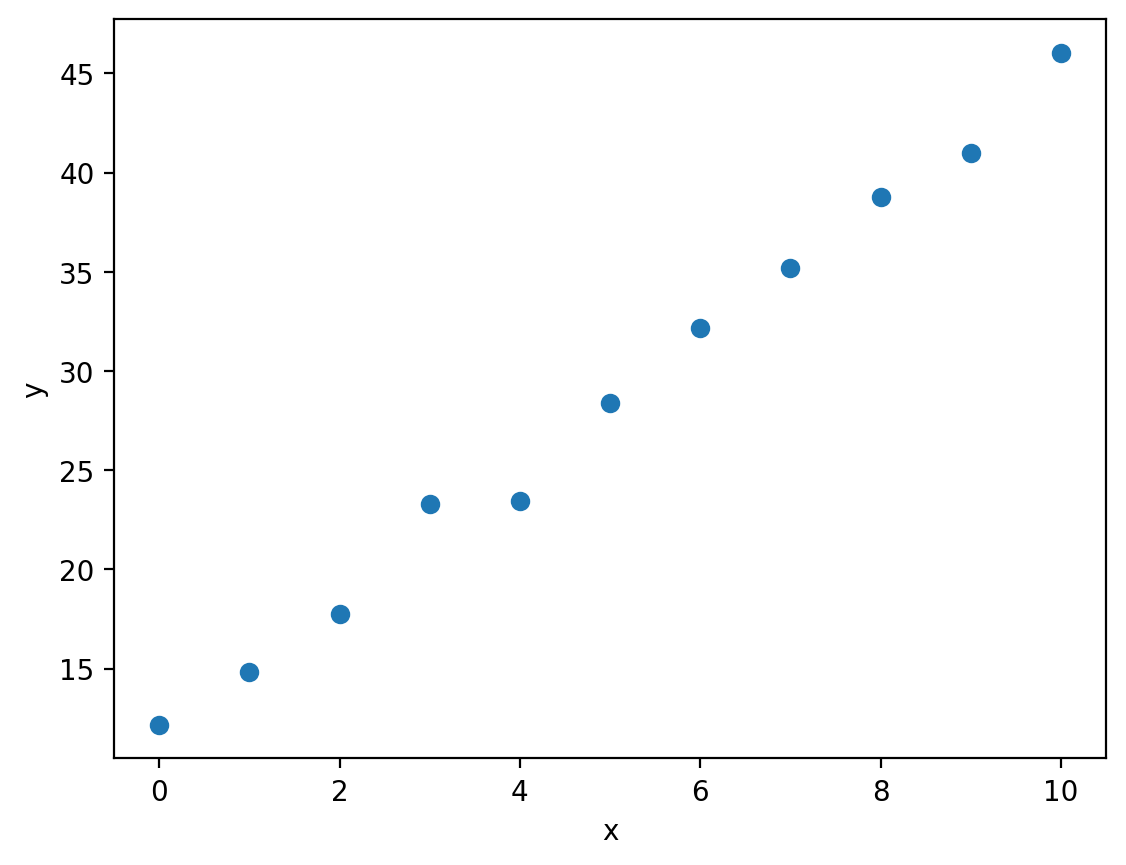

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 11, 1)
y = (3.45 * x + 11.11) + np.random.normal(size=len(x))

plt.plot(x, y, 'o')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In order to find a **line of best fit**, we would like to do [linear regression](https://en.wikipedia.org/wiki/Linear_regression). In short, we want to find the line:

$$y = mx + c,$$

(where $m$ is the slope and $c$ is the intercept), that is as close as possible to all the experimental data points. There are many ways to do linear regression in Python, but perhaps the simplest is the `linregress` function from the `scipy` library:

In [3]:
from scipy.stats import linregress

regression_data = linregress(x, y)

print(regression_data)

LinregressResult(slope=3.3576091682235556, intercept=11.661981449540097, rvalue=0.9969800404120258, pvalue=2.6640394115244366e-11, stderr=0.08717859216045439, intercept_stderr=0.5157555065995508)


The first thing you might notice about the code above is that the `import` statement looks a little different to those we have seen before. The `from` keyword allows to import individual functions or constants from a package rather than the whole thing. In this example, we have imported **just the linregress function**, which means we can **call** that function by typing `linregress(x, y)` rather than running `import scipy` and then having to type out `scipy.stats.linregress(x, y)`. To further clarify this, you may recall that we have made frequent use of `scipy` to access important physical constants such as $h$ and $k_{\mathrm{B}}$ by typing `scipy.constants.h` or `scipy.constants.k`. Using the `from` keyword, we could instead type:

In [4]:
from scipy.constants import h, k

print(h, k)

6.62607015e-34 1.380649e-23


Coming back to the rest of our linear regression code, we **called** the `linregress` functions with two arguments: `x` and `y`:

```python
regression_data = linregress(x, y)
```

These variables contain the experimental $x$ and $y$-data as plotted previously. We stored the output of the `linregress` function in a variable called `regression_data` and then passed this to the `print` function:

```python
print(regression_data)
```

The information **returned** from the `linregress` function contains the slope $m$ and the intercept $c$ of the line of best fit, alongside other useful information such as the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) $r$:

In [5]:
regression_data

LinregressResult(slope=3.3576091682235556, intercept=11.661981449540097, rvalue=0.9969800404120258, pvalue=2.6640394115244366e-11, stderr=0.08717859216045439, intercept_stderr=0.5157555065995508)

We can access the slope $m$ and the intercept $c$ as `regression_data.slope` and `regression_data.intercept` respectively:

In [6]:
print(f'm = {regression_data.slope}')
print(f'c = {regression_data.intercept}')

m = 3.3576091682235556
c = 11.661981449540097


We now have all the information we need to construct and plot our **line of best fit**:

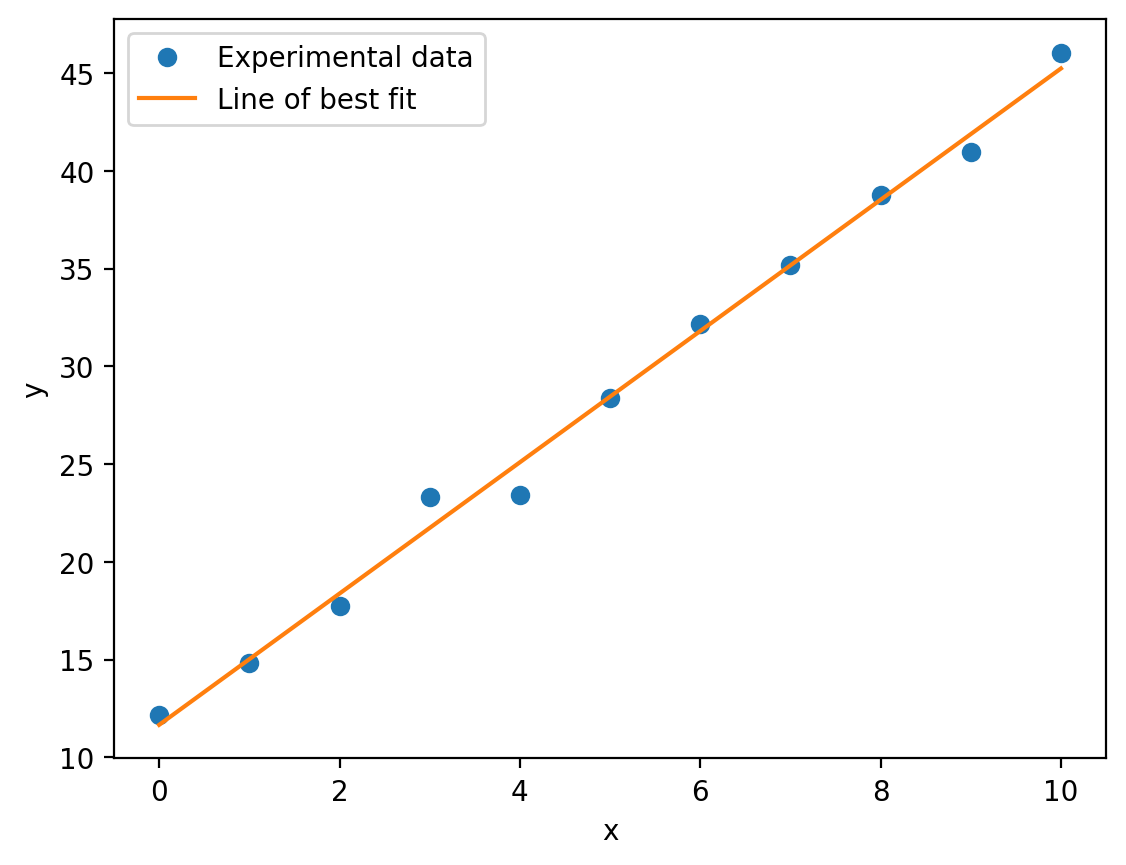

In [7]:
y_best_fit = regression_data.slope * x + regression_data.intercept # y = mx + c

plt.plot(x, y, 'o', label='Experimental data')
plt.plot(x, y_best_fit, label='Line of best fit')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.show()

It's worth emphasising at this stage that whilst the example is wholly abstract ($x$ and $y$ have no physical meaning and have no units), the same procedure could easily be applied to any linear dataset you might wish to analyse.

In addition to the slope and intercept of the line of best fit, the `linregress` function also gives us access to the standard **error** associated with both values via `regression_data.stderr` and `regression_data.st:

In [8]:
print(f'm = {regression_data.slope} +/- {regression_data.stderr}')
print(f'c = {regression_data.intercept} +/- {regression_data.intercept_stderr}')

m = 3.3576091682235556 +/- 0.08717859216045439
c = 11.661981449540097 +/- 0.5157555065995508


These errors are 95% [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval) calculated without any knowledge of the uncertainties in the experimental measurements.

To properly account for the uncertainties associated with measurement, and to propagate these uncertaintes through to the slope $m$ and the intercept $c$ of our **line of best fit**, we require more sophisticated methods.

## Accounting for uncertainties

Let's add some uncertainty to the experimental $y$-data from our previous example:

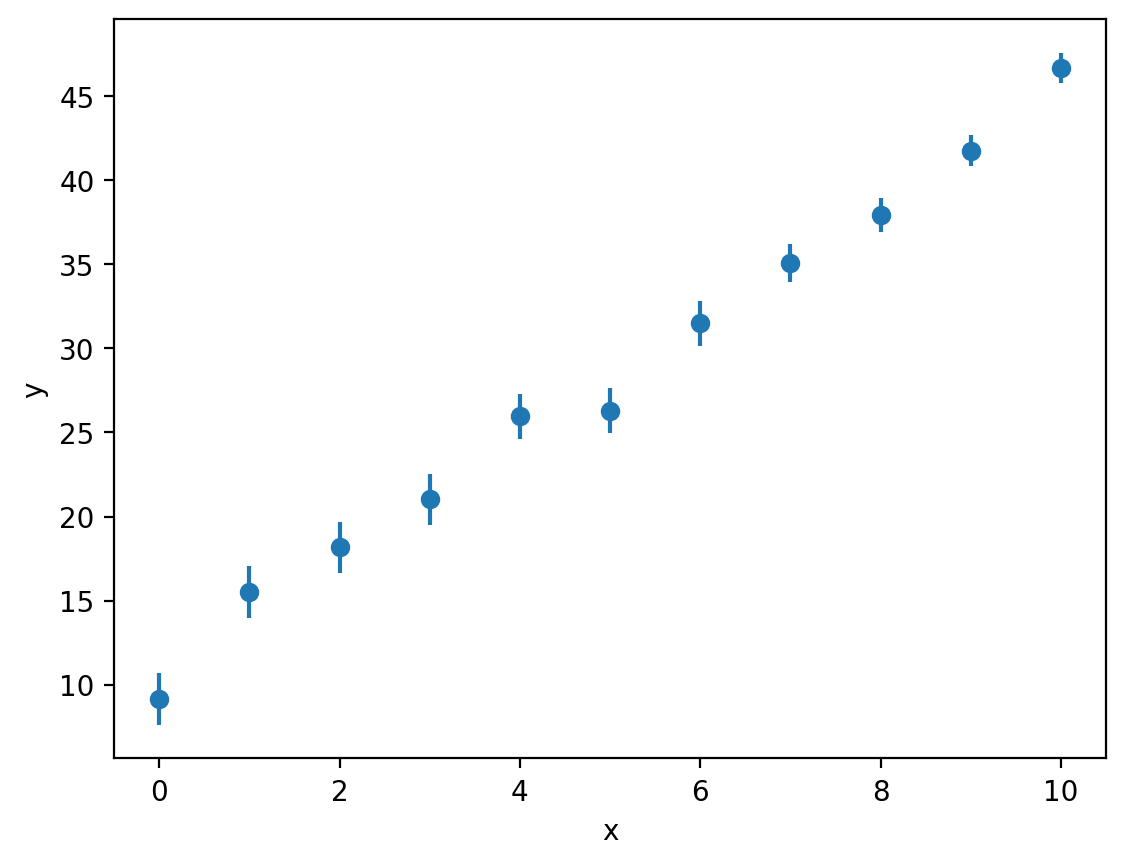

In [9]:
x = np.arange(0, 11, 1)
y = (3.45 * x + 11.11) + np.random.normal(size=len(x))
y_err = [1.55, 1.55, 1.53, 1.53, 1.33, 1.33, 1.33, 1.12, 1.02, 0.9, 0.9]

plt.errorbar(x, y, y_err, fmt='o')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

As you can see above, we can plot error bars using `plt.errorbar`, passing the size of each error bar as a **third** argument (here passed as the variable `y_err`). The `fmt` keyword argument is used to prevent `matplotlib` from joining each point with a line (this is roughly equivalent how we can pass strings such as `'o'` or `'o-'` to the `plt.plot` function to change how the data is rendered).

To perform linear regression on this dataset that explicitly **accounts for the error bars**, we are going to use the `curve_fit` function:

In [10]:
from scipy.optimize import curve_fit

Given that we're trying to fit a **straight line**, you might be wondering why on earth we're using a function called **curve**_fit. Simply put, `curve_fit` is a much more robust general-use function that `linregress` (it can be used to do **non-linear** regression as well as **linear** regression) and it has a keyword argument `sigma` that can be used to explicitly account for uncertainties in the experimental $y$-data.

To use the `curve_fit` function, we have to define the model that we would like to fit to our data. That might sound a little vague, so let's be more concrete: we are trying to fit a straight line, therefore our "model" for the experimental data is:

$$y = mx + c,$$

where $m$ is the slope and $c$ is the intercept. We can define this model in Python as a **function**:

In [11]:
def straight_line(x, m, c):
    """
    Calculate y = mx + c (the equation of a straight line).

    Args:
        x (np.ndarray): A numpy array containing all of the x-values.
        m (float): The slope of the line.
        c (float): The y-intercept of the line.

    Returns:
        (np.ndarray): The y-values.
    """

    return m * x + c

We can now pass our function **as an argument** to `curve_fit`, also passing the experimental $x$ and $y$ data as well as the uncertainties using the `sigma` keyword argument:

In [12]:
regression_data = curve_fit(straight_line, x, y, sigma=y_err)

`curve_fit` **returns** a `tuple` of two elements:

In [13]:
regression_data

(array([ 3.52644657, 10.45120648]),
 array([[ 0.01011898, -0.0635017 ],
        [-0.0635017 ,  0.49666583]]))

The first of these is a `numpy` array containing the optimised parameters for our model in the order they are specified in the function definition. In this case, our `straight_line` function takes the arguments `x`, `m` and `c`:

```python
def straight_line(x, m, c):
```

`m` comes before `c`, so the same order will be reflected in the optimised parameters:

In [14]:
regression_data[0]

array([ 3.52644657, 10.45120648])

The second element of `regression_data` is the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix), again in the form of a `numpy` array:

In [15]:
regression_data[1]

array([[ 0.01011898, -0.0635017 ],
       [-0.0635017 ,  0.49666583]])

Without getting into the underlying statistics, the important data here is on the **diagonal** of this matrix. Again in the same order as specified in the function definition, the diagonal elements of the covariance matrix are the **errors** associated with the slope and the intercept:

In [16]:
slope, intercept = regression_data[0]
covariance_matrix = regression_data[1]
slope_error = covariance_matrix[0, 0] # First element of the diagonal, row 1 column 1
intercept_error = covariance_matrix[1, 1] # Second element of the diagonal, row 2 column 2

print(f'm = {slope} +/- {slope_error}')
print(f'c = {intercept} +/- {intercept_error}')

m = 3.5264465746464184 +/- 0.010118979353261254
c = 10.451206478966807 +/- 0.4966658292474573


Unlike when we used the `linregress` function, these errors actually account for the uncertainties in the experimental data and **propagate** these through to the **error** in $m$ and $c$. We can visualise our fitted model (our line of best fit) just like we did before:

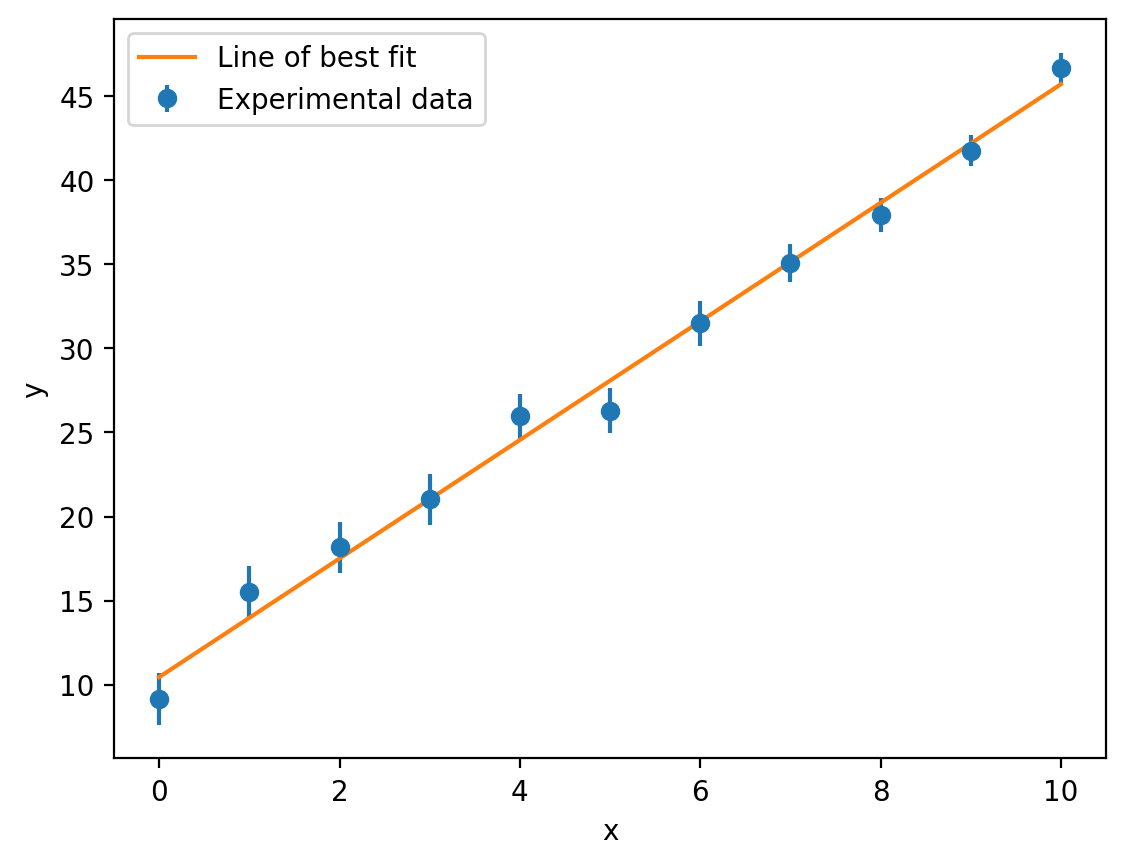

In [17]:
y_model = slope * x + intercept # y = mx + c

plt.errorbar(x, y, y_err, fmt='o', label='Experimental data')
plt.plot(x, y_model, label='Line of best fit')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.show()